In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nostress.db'
session = cc.database.create_session(db)
exps = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

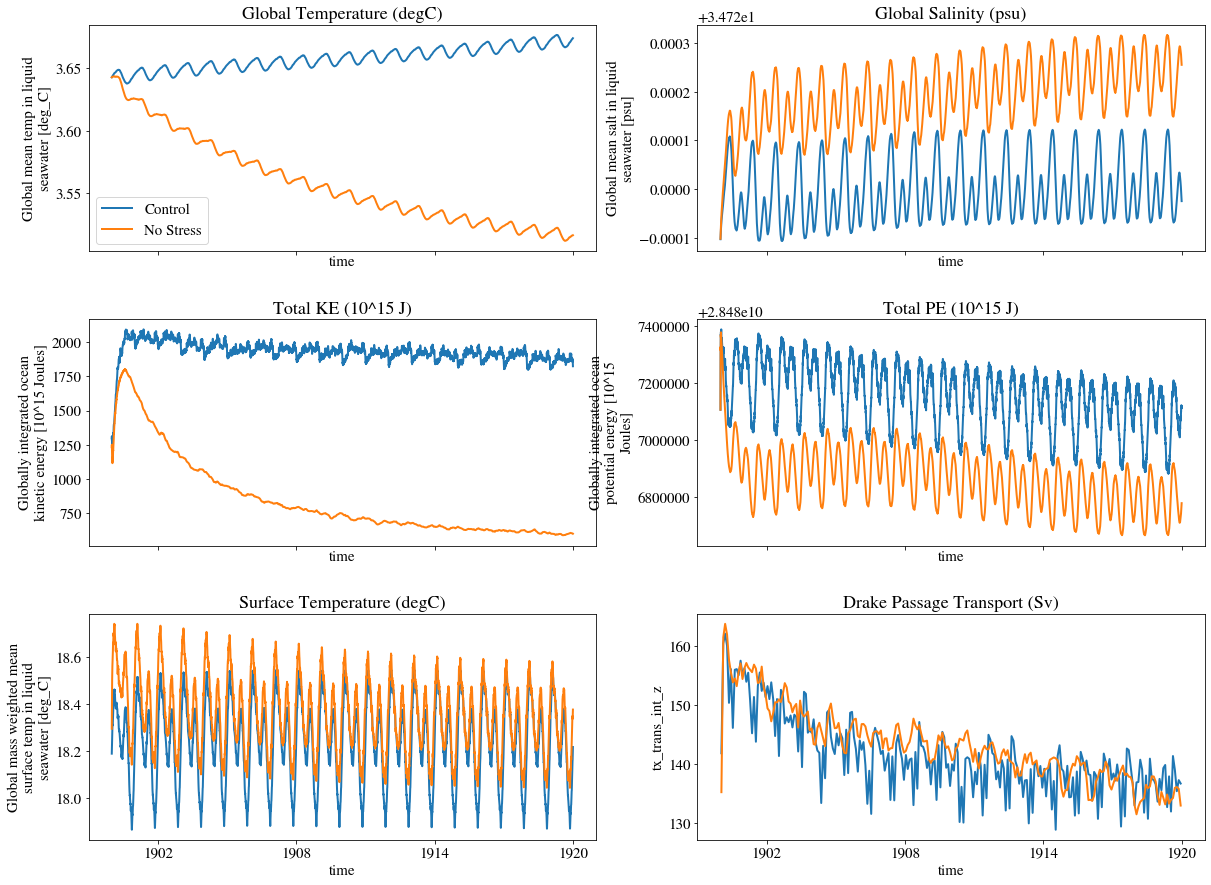

In [3]:
# Scalar time-series:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),facecolor='w',sharex=True)

# Calc DP transport:
xmin, xmax, ymin, ymax = -69.9, -69.9, -71.6, -51.0
rho0=1035.0

for exp in exps:
    cc.querying.getvar(exp,'temp_global_ave',session).plot(ax=axes[0][0],label=names[exp])#.resample(time='A').mean(dim='time')
    cc.querying.getvar(exp,'ke_tot',session).plot(ax=axes[1][0])
    cc.querying.getvar(exp,'salt_global_ave',session).plot(ax=axes[0][1])
    cc.querying.getvar(exp,'pe_tot',session).plot(ax=axes[1][1])
    cc.querying.getvar(exp,'temp_surface_ave',session).plot(ax=axes[2][0])

    DPtrans = cc.querying.getvar(exp,'tx_trans_int_z',session).sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DPtrans.plot(ax=axes[2][1])

axes[0][0].set_title('Global Temperature (degC)')
axes[0][0].legend()
axes[1][0].set_title('Total KE (10^15 J)')
axes[0][1].set_title('Global Salinity (psu)')
axes[1][1].set_title('Total PE (10^15 J)')
axes[2][0].set_title('Surface Temperature (degC)')
axes[2][1].set_title('Drake Passage Transport (Sv)')
plt.subplots_adjust(hspace=0.3)

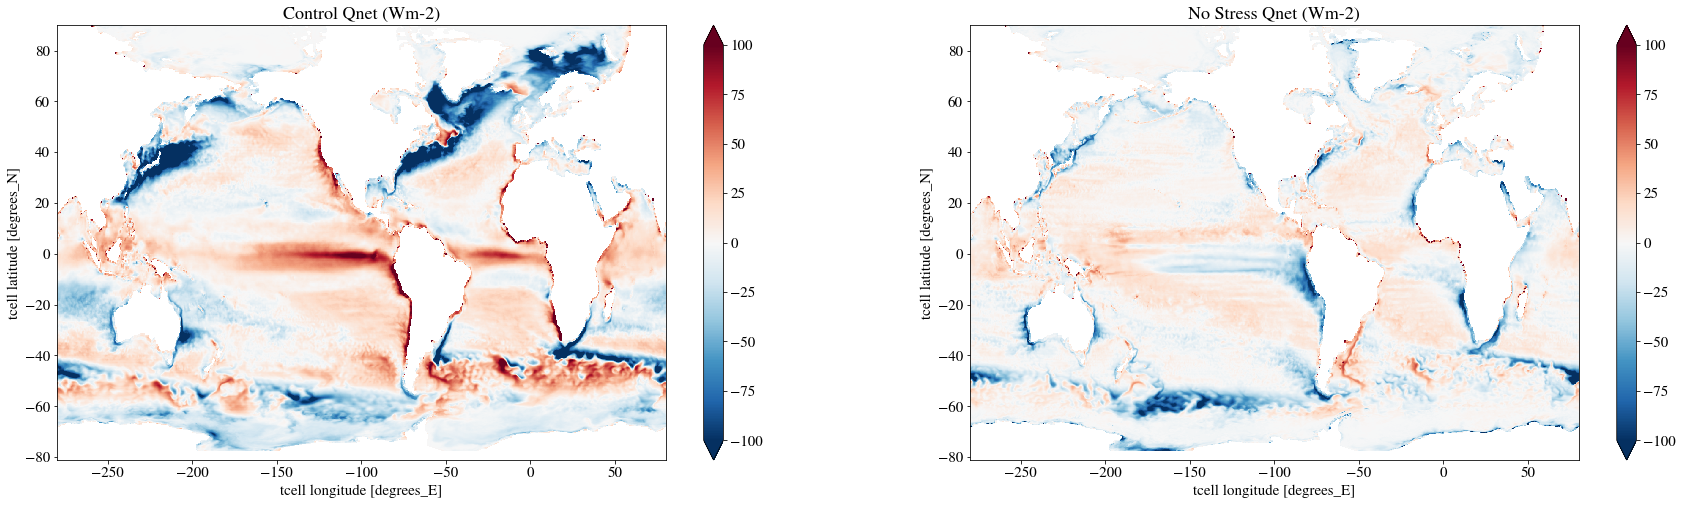

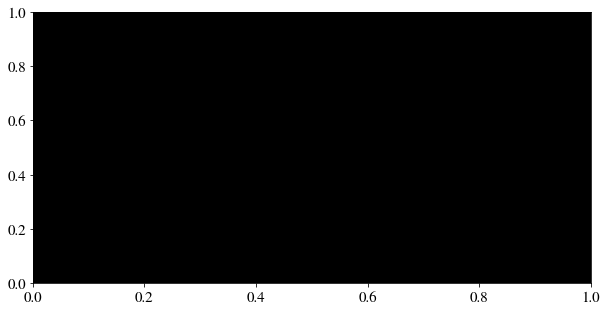

In [9]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,8),facecolor='w')
plt.rcParams['axes.facecolor'] = 'black'
fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(10,5),facecolor='w')
lvls = np.arange(-250, 250, 10)

for i,exp in enumerate(exps):
    Qnet = (cc.querying.getvar(exp, 'net_sfc_heating', session,n=-1)+cc.querying.getvar(exp, 'frazil_3d_int_z', session,n=-1)).mean('time')
    Qnet.plot(ax=axes[i],vmin=-100.,vmax=100.,cmap='RdBu_r')
    axes[i].set_title(names[exp] + ' Qnet (Wm-2)')

In [4]:
cc.querying.get_variables(session, experiment='025deg_jra55_ryf_nostress_cont', frequency='1 monthly')

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
2,HTE,T cell width on East side,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
3,HTN,T cell width on North side,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
4,NCAT,category maximum thickness,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
...,...,...,...,...,...,...,...
175,wt,dia-surface velocity T-points,1 monthly,output009/ocean/ocean-3d-wt-1-monthly-mean-ym_...,20,1900-01-01 00:00:00,1920-01-01 00:00:00
176,xt_ocean,tcell longitude,1 monthly,output009/ocean/ocean-2d-sfc_hflux_pme-1-month...,1112,1900-01-01 00:00:00,1920-01-01 00:00:00
177,xu_ocean,ucell longitude,1 monthly,output009/ocean/ocean-2d-tau_x-1-monthly-mean-...,278,1900-01-01 00:00:00,1920-01-01 00:00:00
178,yt_ocean,tcell latitude,1 monthly,output009/ocean/ocean-2d-sfc_hflux_pme-1-month...,1060,1900-01-01 00:00:00,1920-01-01 00:00:00


### Plotting u and v velocities

In [4]:
start_time = '01-01-1900'
end_time = '31-12-1920'

u = cc.querying.getvar(exps[1],'u',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
u = u.sel(time = slice('1900-01-01','1920-12-31'))
v = cc.querying.getvar(exps[1],'v',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
v = v.sel(time = slice('1900-01-01','1920-12-31'))

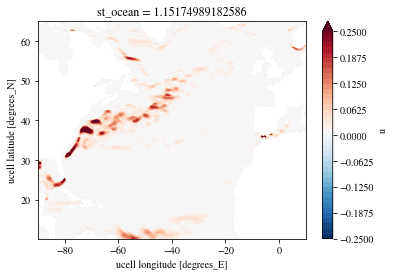

In [39]:
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1901-01-01','1901-12-31')).mean('time').plot.pcolor(
    levels = np.linspace(-0.25,0.25,41))

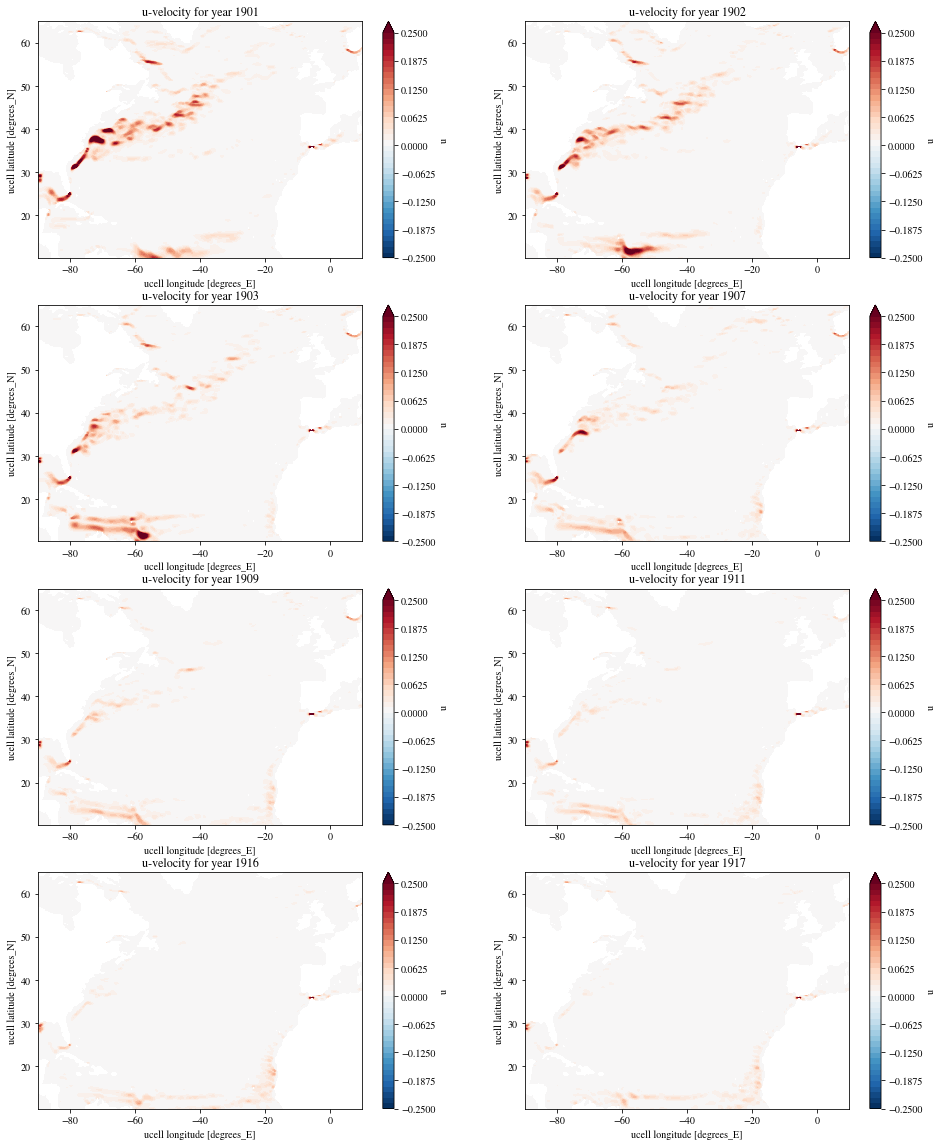

In [38]:
plt.figure(figsize=(16,20))

plt.subplot(421)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1901-01-01','1901-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1901")

plt.subplot(422)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1902-01-01','1902-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1902")

plt.subplot(423)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1903-01-01','1903-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1903")

plt.subplot(424)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1907-01-01','1907-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1907")

plt.subplot(425)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1909-01-01','1909-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1909")

plt.subplot(426)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1911-01-01','1911-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1911")

plt.subplot(427)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1914-01-01','1914-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1916")

plt.subplot(428)
u.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1916-01-01','1916-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("u-velocity for year 1917")

plt.show()

In [75]:
u0 = cc.querying.getvar(exps[1],'u',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
u0 = u0.sel(time = slice('1900-01-01','1920-12-31'))
v0 = cc.querying.getvar(exps[1],'v',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
v0 = v0.sel(time = slice('1900-01-01','1920-12-31'))

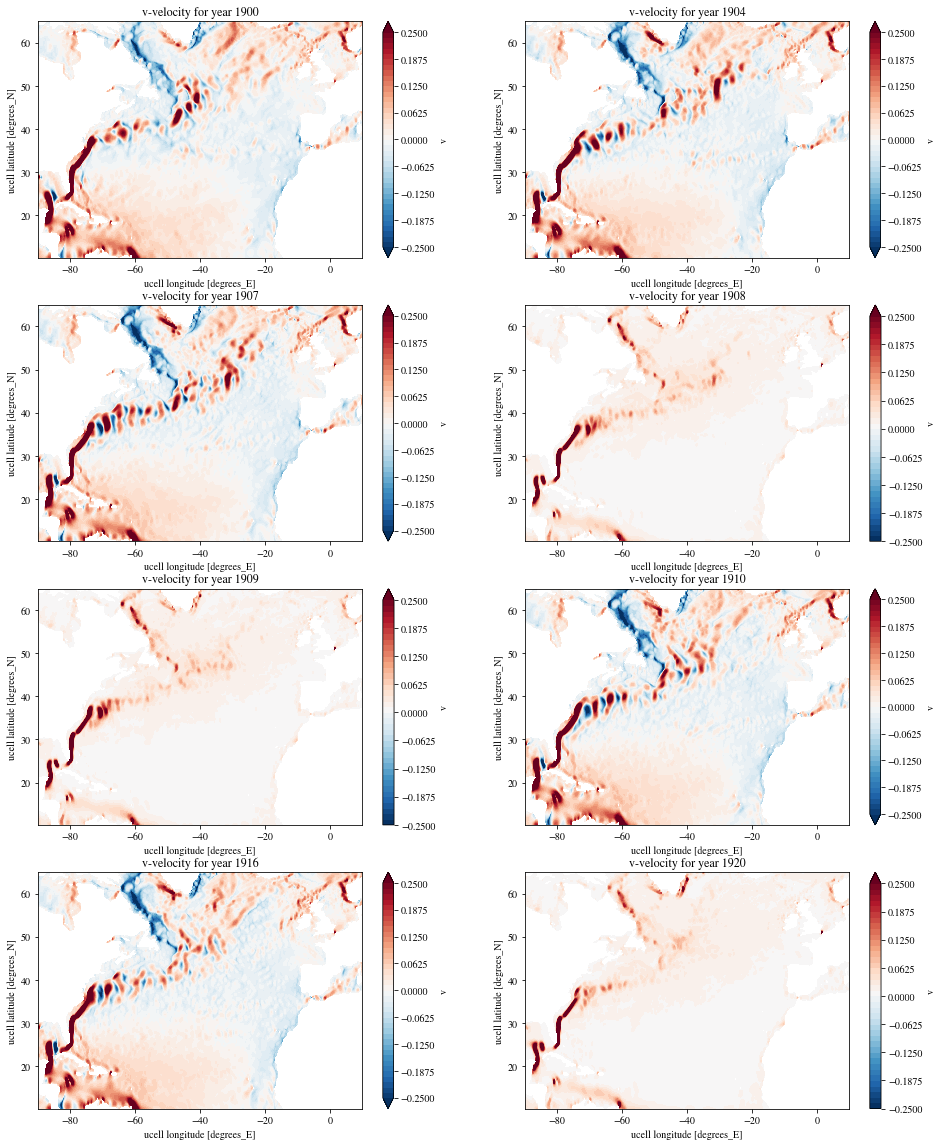

In [16]:
plt.figure(figsize=(16,20))

plt.subplot(421)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1900-01-01','1900-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1900")

plt.subplot(422)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1904-01-01','1904-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1904")

plt.subplot(423)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1907-01-01','1907-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1907")

plt.subplot(424)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1908-01-01','1908-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1908")

plt.subplot(425)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1909-01-01','1909-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1909")

plt.subplot(426)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1912-01-01','1912-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1910")

plt.subplot(427)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1916-01-01','1916-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1916")

plt.subplot(428)
v.sel(st_ocean = 1,method = 'nearest').sel(time = slice('1919-01-01','1919-12-31')).mean('time').plot.contourf(
    levels = np.linspace(-0.25,0.25,41))
plt.title("v-velocity for year 1920")

plt.show()

In [11]:
expt = exps[0]
vars_01deg = cc.querying.get_variables(session, experiment=exps[0])
vars_01deg[vars_01deg['name'].str.lower().str.match('u')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
15,ULAT,U grid center latitude,1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
16,ULON,U grid center longitude,1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
86,uarea,area of U grid cells,1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
87,usurf,i-surface current,1 daily,output007/ocean/ocean-2d-usurf-1-daily-mean-ym...,2,1914-01-01 00:00:00,1916-01-01 00:00:00
88,uvel,ice velocity (x),1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
104,ULAT,U grid center latitude,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
105,ULON,U grid center longitude,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
259,u,i-current,1 monthly,output009/ocean/ocean-3d-u-1-monthly-pow02-ym_...,40,1900-01-01 00:00:00,1920-01-01 00:00:00
260,uarea,area of U grid cells,1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
261,uatm_m,atm velocity (x),1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00


In [5]:
3+2

5

In [14]:
ncview /output009/ice/OUTPUT/iceh.1919-12-31.nc

SyntaxError: invalid syntax (<ipython-input-14-247586d81073>, line 1)